# Project 3

In this project, you will perform a logistic regression on the admissions data we've been working with in projects 1 and 2.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import pylab as pl
import numpy as np
from sklearn import linear_model

C:\Users\sydlea\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
df_raw = pd.read_csv("../assets/admissions.csv")
df = df_raw.dropna() 
print(df.head())

   admit    gre   gpa  prestige
0      0  380.0  3.61       3.0
1      1  660.0  3.67       3.0
2      1  800.0  4.00       1.0
3      1  640.0  3.19       4.0
4      0  520.0  2.93       4.0


## Part 1. Frequency Tables

#### 1. Let's create a frequency table of our variables

In [4]:
# frequency table for prestige and whether or not someone was admitted
prestige_table = pd.crosstab(index=df["admit"],  # Make a crosstab
                              columns=df["prestige"])      # Name the count column

prestige_table.index= ["Not admitted","Admitted"]

prestige_table #print that shizz

prestige,1.0,2.0,3.0,4.0
Not admitted,28,95,93,55
Admitted,33,53,28,12


Can we do that in an easier, less ugly way?

In [5]:
pd.crosstab(df.admit,df.prestige)

prestige,1.0,2.0,3.0,4.0
admit,,,,
0,28,95,93,55
1,33,53,28,12


The answer was yes.

## Part 2. Return of dummy variables

#### 2.1 Create class or dummy variables for prestige 

In [6]:
prestige_dumms = pd.get_dummies(df_raw['prestige'])
prestige_dumms.columns = ["prestige_1","prestige_2","prestige_3","prestige_4"]
df = df.join(prestige_dumms)

In [7]:
df.drop('prestige', inplace=True, axis=1 ) #drop prestige

In [8]:
df.head() #confirming dummie variables

,admit,gre,gpa,prestige_1,prestige_2,prestige_3,prestige_4
0,0,380.0,3.61,0,0,1,0
1,1,660.0,3.67,0,0,1,0
2,1,800.0,4.00,1,0,0,0
3,1,640.0,3.19,0,0,0,1
4,0,520.0,2.93,0,0,0,1


#### 2.2 When modeling our class variables, how many do we need? 



Okay, so I had no idea what the fuck this question was, and still didn't really understand even after asking Chris, but this makes sense: 
<p>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;In other words: if both the vector-of-ones (constant term) regressor and an exhaustive set of dummies are present, perfect multicollinearity occurs,[6] and the system of equations formed by the regression does not have a unique solution. This is referred to as the **dummy variable trap**. The trap can be avoided by removing either the constant term or one of the offending dummies. The removed dummy then becomes the base category against which the other categories are compared. </p>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-From Wikipedia on <a href = "https://en.wikipedia.org/wiki/Dummy_variable_(statistics)">Dummy variables</a>

**So the answer is 3.**

## Part 3. Hand calculating odds ratios

Develop your intuition about expected outcomes by hand calculating odds ratios.

In [9]:
cols_to_keep = ['admit', 'gre', 'gpa']
handCalc = df[cols_to_keep].join(prestige_dumms.loc[:, 'prestige_1':])
print(handCalc.head())

   admit    gre   gpa  prestige_1  prestige_2  prestige_3  prestige_4
0      0  380.0  3.61           0           0           1           0
1      1  660.0  3.67           0           0           1           0
2      1  800.0  4.00           1           0           0           0
3      1  640.0  3.19           0           0           0           1
4      0  520.0  2.93           0           0           0           1


In [10]:
#crosstab prestige 1 admission 
# frequency table cutting prestige and whether or not someone was admitted

pd.crosstab(df.admit,prestige_dumms.prestige_1)

prestige_1,0,1
admit,,
0.0,243,28
1.0,93,33


#### 3.1 Use the cross tab above to calculate the odds of being admitted to grad school if you attended a #1 ranked college

In [11]:
odds_admitted_prestige1 = 33. / 28
odds_admitted_prestige1

1.1785714285714286

#### 3.2 Now calculate the odds of admission if you did not attend a #1 ranked college

In [12]:
odds_admitted_not_prestige1 = 93. / 243
odds_admitted_not_prestige1

0.38271604938271603

#### 3.3 Calculate the odds ratio

In [13]:
odds_ratio = odds_admitted_prestige1/odds_admitted_not_prestige1
odds_ratio

3.079493087557604

#### 3.4 Write this finding in a sentenance: 

For students who attended a prestige one university, the odds of being admitted into graduate school were 3 times the odds of students who did not attend a prestige one university. 

#### 3.5 Print the cross tab for prestige_4

In [14]:
pd.crosstab(df.admit,prestige_dumms.prestige_4)

prestige_4,0,1
admit,,
0.0,216,55
1.0,114,12


#### 3.6 Calculate the OR 

In [15]:
odds_admitted_prestige4 = 12. / 55
odds_admitted_prestige4

odds_admitted_not_prestige4 = 114. / 216
odds_admitted_not_prestige4

odds_ratio = odds_admitted_prestige4/odds_admitted_not_prestige4
odds_ratio

0.4133971291866028

#### 3.7 Write this finding in a sentence

For students who attended a prestige four university, the odds of being admitted into graduate school were .4 times the odds of students who did not attend a prestige four university. 

## Part 4. Analysis

In [16]:
# create a clean data frame for the regression
cols_to_keep = ['admit', 'gre', 'gpa']
data = df[cols_to_keep].join(prestige_dumms.loc[:, 'prestige_2':])
print(data.head())

   admit    gre   gpa  prestige_2  prestige_3  prestige_4
0      0  380.0  3.61           0           1           0
1      1  660.0  3.67           0           1           0
2      1  800.0  4.00           0           0           0
3      1  640.0  3.19           0           0           1
4      0  520.0  2.93           0           0           1


We're going to add a constant term for our Logistic Regression. The statsmodels function we're going to be using requires that intercepts/constants are specified explicitly.

In [17]:
# manually add the intercept
data['intercept'] = 1.0

#### 4.1 Set the covariates to a variable called train_cols

In [39]:
train_cols = data.columns[1:]
train_cols #printing it out, looks right

Index(['gre', 'gpa', 'prestige_2', 'prestige_3', 'prestige_4', 'intercept'], dtype='object')

#### 4.2 Fit the model

In [40]:
model = sm.Logit(data['admit'], data[train_cols]) 

In [44]:
model_result = model.fit() #this wasnt working until removed admit from data.columns above

Optimization terminated successfully.
         Current function value: 0.573854
         Iterations 6


In [46]:
model_result.summary() #printing the result summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  admit   No. Observations:                  397
Model:                          Logit   Df Residuals:                      391
Method:                           MLE   Df Model:                            5
Date:                Fri, 25 Aug 2017   Pseudo R-squ.:                 0.08166
Time:                        14:54:27   Log-Likelihood:                -227.82
converged:                       True   LL-Null:                       -248.08
                                        LLR p-value:                 1.176e-07
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
gre            0.0022      0.001      2.028      0.043    7.44e-05       0.004
gpa            0.7793      0.333      2.344      0.019       0.128       1.431
prestige_2    -0.6801      0.317     -2.146      0.032      -1.301      -0.059
prestige_3    -1.3387      0.345     -3.882      0.000      -2.015      -0.663
prestige_4    -1.5534      0.417     -3.721      0.000      -2.372      -0.735
intercept     -3.8769      1.142     -3.393      0.001      -6.116      -1.638
==============================================================================
"""

#### 4.4 Calculate the odds ratios of the coeffiencents and their 95% CI intervals

hint 1: np.exp(X)

hint 2: conf['OR'] = params
        
           conf.columns = ['2.5%', '97.5%', 'OR']

In [49]:
np.exp(model_result.params)

gre           1.002221
gpa           2.180027
prestige_2    0.506548
prestige_3    0.262192
prestige_4    0.211525
intercept     0.020716
dtype: float64

In [52]:
params = model_result.params
conf = model_result.conf_int()
conf['OR'] = params
conf.columns = ['2.5%', '97.5%', 'OR']
print (np.exp(conf))

                2.5%     97.5%        OR
gre         1.000074  1.004372  1.002221
gpa         1.136120  4.183113  2.180027
prestige_2  0.272168  0.942767  0.506548
prestige_3  0.133377  0.515419  0.262192
prestige_4  0.093329  0.479411  0.211525
intercept   0.002207  0.194440  0.020716


#### 4.5 Interpret the OR of Prestige_2

Students who attended a tier 2 university had .50 the odds of being admitted to graduated school compared to students who attend a tier 1 university. 

#### 4.6 Interpret the OR of GPA

The likelihood of being admitted double as you increase the GPA by 1. 

## Part 5: Predicted probablities


As a way of evaluating our classifier, we're going to recreate the dataset with every logical combination of input values. This will allow us to see how the predicted probability of admission increases/decreases across different variables. First we're going to generate the combinations using a helper function called cartesian (above).

We're going to use np.linspace to create a range of values for "gre" and "gpa". This creates a range of linearly spaced values from a specified min and maximum value--in our case just the min/max observed values.

In [61]:
## use statsmodel cartesian
from sklearn.utils.extmath import cartesian

In [62]:
#import cartesian from sklearn
from sklearn.utils.extmath import cartesian
# instead of generating all possible values of GRE and GPA, we're going
# to use an evenly spaced range of 10 values from the min to the max 
gres = np.linspace(data['gre'].min(), data['gre'].max(), 10)
print(gres)
# array([ 220.        ,  284.44444444,  348.88888889,  413.33333333,
#         477.77777778,  542.22222222,  606.66666667,  671.11111111,
#         735.55555556,  800.        ])
gpas = np.linspace(data['gpa'].min(), data['gpa'].max(), 10)
print(gpas)
# array([ 2.26      ,  2.45333333,  2.64666667,  2.84      ,  3.03333333,
#         3.22666667,  3.42      ,  3.61333333,  3.80666667,  4.        ])

[ 220.          284.44444444  348.88888889  413.33333333  477.77777778
  542.22222222  606.66666667  671.11111111  735.55555556  800.        ]
[ 2.26        2.45333333  2.64666667  2.84        3.03333333  3.22666667
  3.42        3.61333333  3.80666667  4.        ]


#### 5.1 Recreate the dummy variables

In [63]:
 # enumerate all possibilities
combos = pd.DataFrame(cartesian([gres, gpas, [1, 2, 3, 4], [1.]]),columns = ['gre','gpa','prestige','intercept'])
combos.head()
# recreate the dummy variables

,gre,gpa,prestige,intercept
0,220.0,2.260000,1.0,1.0
1,220.0,2.260000,2.0,1.0
2,220.0,2.260000,3.0,1.0
3,220.0,2.260000,4.0,1.0
4,220.0,2.453333,1.0,1.0


In [64]:

# recreate the dummy variables
prestige_dumms = pd.get_dummies(combos['prestige'], prefix = 'prestige') #this will recreate our dummy variables
prestige_dumms.columns = ['prestige_1', 'prestige_2', 'prestige_3', 'prestige_4'] #this will indicate our dummy variable column names

# keep only what we need for making predictions

cols_to_keep = ['gre', 'gpa', 'prestige', 'intercept'] #these are the columns we will want to keep
combos = combos[cols_to_keep].join(prestige_dumms.loc[:, 'prestige_1':]) #this joins the dummy variable back into our updated data set

In [65]:
combos.head()

,gre,gpa,prestige,intercept,prestige_1,prestige_2,prestige_3,prestige_4
0,220.0,2.260000,1.0,1.0,1,0,0,0
1,220.0,2.260000,2.0,1.0,0,1,0,0
2,220.0,2.260000,3.0,1.0,0,0,1,0
3,220.0,2.260000,4.0,1.0,0,0,0,1
4,220.0,2.453333,1.0,1.0,1,0,0,0


#### 5.2 Make predictions on the enumerated dataset

In [67]:
combos['admit_pred'] = model_result.predict(combos[train_cols])

combos.tail(4)

,gre,gpa,prestige,intercept,prestige_1,prestige_2,prestige_3,prestige_4,admit_pred
396,800.0,4.0,1.0,1.0,1,0,0,0,0.734040
397,800.0,4.0,2.0,1.0,0,1,0,0,0.582995
398,800.0,4.0,3.0,1.0,0,0,1,0,0.419833
399,800.0,4.0,4.0,1.0,0,0,0,1,0.368608


#### 5.3 Interpret findings for the last 4 observations

Answer: 

## Bonus

Plot the probability of being admitted into graduate school, stratified by GPA and GRE score.

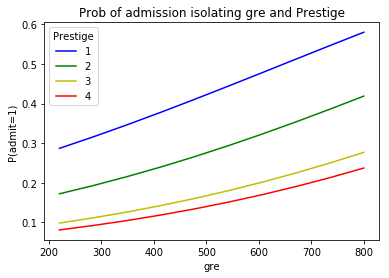

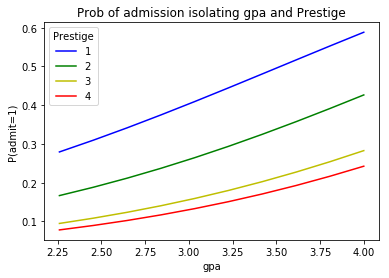

In [96]:
def isolate_and_plot(variable):
 # isolate gre and class rank
    grouped = pd.pivot_table(combos, values=['admit_pred'], index=[variable, 'prestige'],
                            aggfunc=np.mean)
    
# make a plot
    colors = 'rbgyrbgy'
    for col in combos.prestige.unique():
        plt_data = grouped.loc[grouped.index.get_level_values(1)==col]
        pl.plot(plt_data.index.get_level_values(0), plt_data['admit_pred'],
                color=colors[int(col)])

    pl.xlabel(variable)
    pl.ylabel("P(admit=1)")
    pl.legend(['1', '2', '3', '4'], loc='upper left', title='Prestige')
    pl.title("Prob of admission isolating " + variable + " and Prestige") #title since you asked
    pl.show()

isolate_and_plot('gre')
isolate_and_plot('gpa')